In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from fastai.imports import *
import fastai
import fastai.utils.collect_env
from fastai.widgets import *
fastai.utils.collect_env.show_install(1)
from fastai import *
from fastai.vision import *



```text
=== Software === 
python       : 3.6.6
fastai       : 1.0.60
fastprogress : 0.2.2
torch        : 1.4.0
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Linux-5.4.104+-x86_64-with-debian-9.9
distro       : #1 SMP Tue Apr 6 09:49:56 PDT 2021
conda env    : Unknown
python       : /opt/conda/bin/python
sys.path     : /kaggle/lib/kagglegym
/kaggle/lib
/opt/conda/lib/python36.zip
/opt/conda/lib/python3.6
/opt/conda/lib/python3.6/lib-dynload

/root/.local/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages
/src/bq-helper
/opt/conda/lib/python3.6/site-packages/IPython/extensions
/root/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run this utility to ge

In [3]:
path_img = '/kaggle/input/hetomjerry/TJ-Images/TrainImages'
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/kaggle/input/hetomjerry/TJ-Images/TrainImages/image233.jpg'),
 PosixPath('/kaggle/input/hetomjerry/TJ-Images/TrainImages/image106.jpg'),
 PosixPath('/kaggle/input/hetomjerry/TJ-Images/TrainImages/image27.jpg'),
 PosixPath('/kaggle/input/hetomjerry/TJ-Images/TrainImages/image109.jpg'),
 PosixPath('/kaggle/input/hetomjerry/TJ-Images/TrainImages/image56.jpg')]

In [4]:
df1 = pd.read_csv('/kaggle/input/tomandjerry/Dataset/Train.csv', header='infer')
df1.replace(regex=['frame'], value='image',inplace= True)
df1.head()

,Frame_ID,Emotion
0,image0.jpg,happy
1,image1.jpg,happy
2,image2.jpg,surprised
3,image3.jpg,surprised
4,image4.jpg,angry


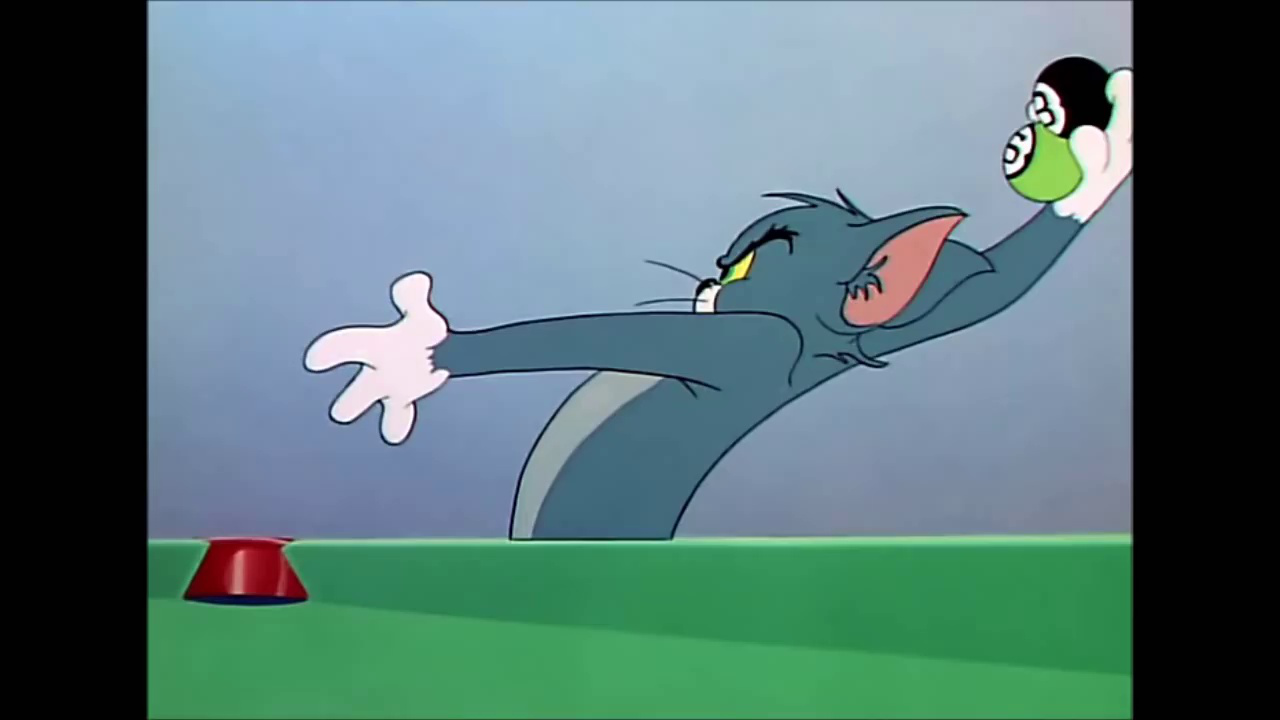

In [5]:
tfms = get_transforms( max_rotate=5, max_lighting=0.3, max_warp=0.2, max_zoom=1.2)
test_df = pd.read_csv('/kaggle/input/tomandjerry/Dataset/Test.csv', header='infer')
test_df.replace(regex=['test'], value='image',inplace= True)
test_df.head()
test_images = ImageList.from_df(test_df, path='/kaggle/input/hetomjerry/TJ-Images/TestImages')
test_images[0]

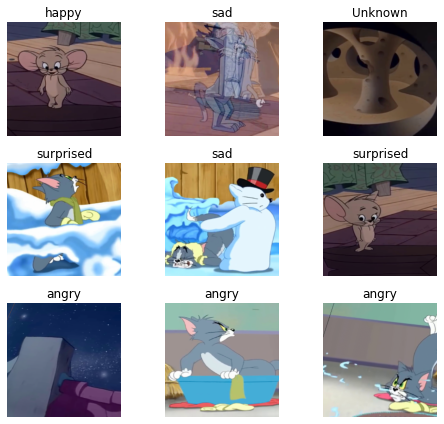

In [7]:
data = ImageDataBunch.from_df(path_img,\
                              df1, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)#.add_test(test_images)
#test = ImageList.from_df(test_df, '../input/gala-hackerearth/dataset/Test Images')
data.add_test(test_images)
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
print(data.c)

['Unknown', 'angry', 'happy', 'sad', 'surprised']
5


In [14]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy, AUROC(),error_rate]).mixup()#error_rate
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
#lr = 1e-5
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,auroc,error_rate,time
0,2.554284,10.602933,0.152542,0.803704,0.847458,00:29
1,2.347222,6.950277,0.237288,0.729630,0.762712,00:28


In [16]:
learn.model_dir = '/kaggle/working'
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(2)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=2)

In [ ]:
predictions_D, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions_D, 1)
#print(predictions_D)
test_df['Class'] = labels
test_df['Class'] = test_df['Class'].map({0: 'Unknown', 1: 'angry', 2:  'happy', 3:  'sad',4:'surprised'})
test_df.replace(regex=['image'], value='test',inplace= True)
#test_df.replace(regex=['Class'], value='Emotion',inplace= True)
print(test_df)
test_df.to_csv('submission_R34.csv')